In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2
import random

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

torch.manual_seed(random.randint(1,1000))

In [4]:
class ImageDataset(Dataset):
    def __init__(self,root_real,root_masked,root_binary,transform=None):
        self.transform = transform
        self.files_masked = sorted(glob.glob(root_masked+"/*.*"))
        self.files_binary = sorted(glob.glob(root_binary+"/*.*"))
        self.files_real = sorted(glob.glob(root_real+"/*.*"))

    def __getitem__(self,index):
        item_masked = self.transform(Image.open(self.files_masked[index%len(self.files_masked)]))
        item_binary = self.transform(Image.open(self.files_binary[index%len(self.files_binary)]))
        item_real = self.transform(Image.open(self.files_real[index%len(self.files_real)]))
        return (item_real-0.5)*2,(item_masked-0.5)*2,(item_binary-0.5)*2

    def __len__(self):
        return min(len(self.files_masked),len(self.files_binary))

In [5]:
maskedImage ="/content/drive/MyDrive/Capstone/dataset/Dataset2/GroundTruth_masked"
binarySeg = "/content/drive/MyDrive/Capstone/dataset/Dataset2/GroundTruth_binary"
realImage = "/content/drive/MyDrive/Capstone/dataset/Dataset2/GroundTruth"

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor()
])

In [7]:
def resize(img):
  resImg = cv2.imread(img)
  resImg = resImg.astype(np.float32)
  resImg = cv2.resize(resImg,(224,224))
  cv2.imwrite(img,resImg)

In [8]:
# for i in os.listdir(realImage):
#   path = os.path.join(realImage,i)
#   # resize(path)

In [9]:
# s = sorted(glob.glob(realImage+'/*.*'))
# m = sorted(glob.glob(maskedImage+'/*.*'))
# b = sorted(glob.glob(binarySeg+'/*.*'))
s = []
m = []
b = []
for i in os.listdir(realImage):
  s.append(i)
for j in  os.listdir(maskedImage):
  m.append(j)
for k in os.listdir(binarySeg):
  b.append(k)
print(s)
print(m)
print(b)
print(len(s),len(m),len(b))
res = []
for i in s:
  if i not in m:
    res.append(i)
print(res)
print(len(res))
# s[1] = resize(s[1])

# s_i = transform(Image.open(s[1]))
# print(s_i.shape)

['00170.jpg', '00166.jpg', '00188.jpg', '00165.jpg', '00181.jpg', '00187.jpg', '00194.jpg', '00180.jpg', '00154.jpg', '00183.jpg', '00162.jpg', '00161.jpg', '00167.jpg', '00182.jpg', '00174.jpg', '00150.jpg', '00156.jpg', '00151.jpg', '00147.jpg', '00160.jpg', '00149.jpg', '00195.jpg', '00172.jpg', '00142.jpg', '00146.jpg', '00169.jpg', '00186.jpg', '00171.jpg', '00157.jpg', '00153.jpg', '00163.jpg', '00155.jpg', '00168.jpg', '00164.jpg', '00143.jpg', '00177.jpg', '00173.jpg', '00140.jpg', '00148.jpg', '00199.jpg', '00221.jpg', '00249.jpg', '00202.jpg', '00237.jpg', '00200.jpg', '00207.jpg', '00197.jpg', '00246.jpg', '00224.jpg', '00244.jpg', '00239.jpg', '00242.jpg', '00213.jpg', '00208.jpg', '00220.jpg', '00228.jpg', '00227.jpg', '00206.jpg', '00212.jpg', '00240.jpg', '00201.jpg', '00205.jpg', '00238.jpg', '00243.jpg', '00235.jpg', '00211.jpg', '00241.jpg', '00222.jpg', '00247.jpg', '00223.jpg', '00198.jpg', '00226.jpg', '00219.jpg', '00231.jpg', '00236.jpg', '00196.jpg', '00225.jpg'

In [10]:
dataset = ImageDataset(realImage,maskedImage,binarySeg,transform)

In [11]:
train = DataLoader(dataset,batch_size=1,shuffle=False)

In [12]:
def convertRGB(path):
  from PIL import Image


  gray_image = Image.open(path)

  rgb_image = Image.new("RGB", gray_image.size)

  rgb_image.paste(gray_image)

  rgb_image.save(path)


In [13]:

# for i in os.listdir(binarySeg):
#   path = os.path.join(binarySeg,i)
#   convertRGB(path)


torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


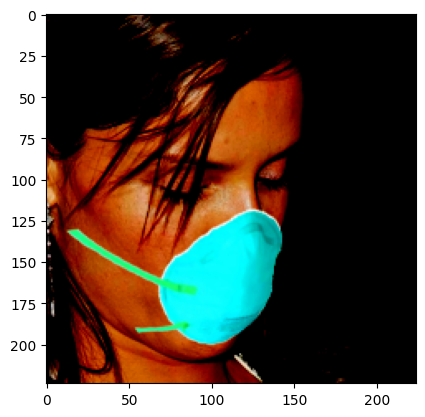

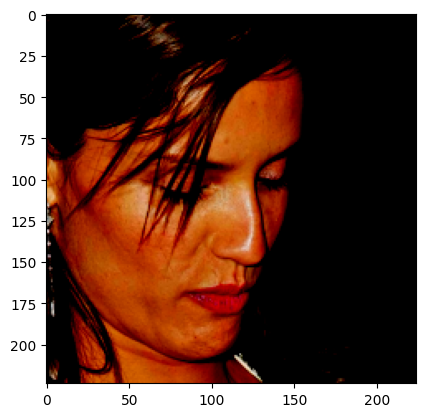

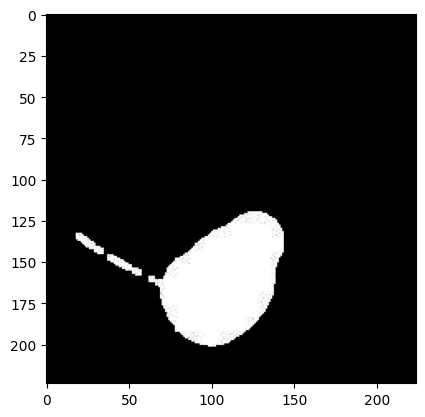

In [14]:
train_x,train_y,x = next(iter(train))
print(train_x.size(),train_y.size(),x.size())
# print(train_y)
masked = train_y[0].squeeze()
masked = masked.permute(1,2,0)
plt.imshow(masked)
plt.show()
real = train_x[0].squeeze()
# print(Maskimage.shape)
# t = transforms.Resize((254, 254))
real = real.permute(1,2,0)
plt.imshow(real)
plt.show()

binary = x[0].squeeze()
binary = binary.permute(1,2,0)
plt.imshow(binary)
plt.show()



In [15]:
def crop(image,new_shape):
    middle_height = image.shape[2]//2
    middle_width = image.shape[3]//2
    starting_height = middle_height-round(new_shape[2]/2)
    final_height = starting_height+new_shape[2]
    starting_width = middle_width-round(new_shape[3]/2)
    final_width = starting_width+new_shape[3]
    cropped_image = image[:,:,starting_height:final_height,starting_width:final_width]
    return cropped_image

In [16]:
class ContractingBlock(nn.Module):
    def __init__(self,input_channels,use_in=True,use_dropout=False):
        super(ContractingBlock,self).__init__()
        self.conv = nn.Conv2d(input_channels,input_channels*2,kernel_size=3,padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        if use_in:
            self.insnorm = nn.InstanceNorm2d(input_channels*2)
        self.use_in = use_in
        if use_dropout:
            self.drop = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self,x):
        x = self.conv(x)
        if self.use_in:
            x = self.insnorm(x)
        if self.use_dropout:
            x = self.drop(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x


class ExpandingBlock(nn.Module):
    def __init__(self,input_channels,use_in=True):
        super(ExpandingBlock,self).__init__()
        self.tconv = nn.ConvTranspose2d(input_channels,input_channels//2,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.conv2 = nn.Conv2d(input_channels,input_channels//2,kernel_size=3,padding=1)
        self.activation = nn.LeakyReLU(0.2)
        if use_in:
            self.insnorm = nn.InstanceNorm2d(input_channels//2)
        self.use_in = use_in

    def forward(self,x,skip_x):
        x = self.tconv(x)
        skip_x = crop(skip_x,x.shape)
        x = torch.cat([x,skip_x],axis=1)
        x = self.conv2(x)
        if self.use_in:
            x = self.insnorm(x)
        x = self.activation(x)
        return x


class FeatureMapBlock(nn.Module):
    def __init__(self,input_channels,output_channels):
        super(FeatureMapBlock,self).__init__()
        self.conv = nn.Conv2d(input_channels,output_channels,kernel_size=1)

    def forward(self,x):
        x = self.conv(x)
        return x


class SE_Block(nn.Module):
    def __init__(self,channels,reduction=16):
        super(SE_Block,self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels,channels//reduction,bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels//reduction,channels,bias=False),
            nn.Sigmoid()
        )
    def forward(self,x):
        b, c, _, _ = x.shape
        y = self.squeeze(x).view(b,c)
        y = self.excitation(y).view(b,c,1,1)
        return x * y.expand_as(x)


class AtrousConv(nn.Module):
    def __init__(self,input_channels):
        super(AtrousConv,self).__init__()
        self.aconv2 = nn.Conv2d(input_channels,input_channels,kernel_size=3,stride=1,dilation=2,padding=2)
        self.aconv4 = nn.Conv2d(input_channels,input_channels,kernel_size=3,stride=1,dilation=4,padding=4)
        self.aconv8 = nn.Conv2d(input_channels,input_channels,kernel_size=3,stride=1,dilation=8,padding=8)
        self.aconv16 = nn.Conv2d(input_channels,input_channels,kernel_size=3,stride=1,dilation=16,padding=16)
        self.batchnorm = nn.BatchNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self,x):
        x = self.aconv2(x)
        x = self.batchnorm(x)
        x = self.activation(x)

        x = self.aconv4(x)
        x = self.batchnorm(x)
        x = self.activation(x)

        x = self.aconv8(x)
        x = self.batchnorm(x)
        x = self.activation(x)

        x = self.aconv16(x)
        x = self.batchnorm(x)
        x = self.activation(x)

        return x


In [17]:
class UNet(nn.Module):
    def __init__(self,input_channels,output_channels,hidden_channels=32):
        super(UNet,self).__init__()
        self.upfeature = FeatureMapBlock(input_channels,hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels,use_in=False,use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels*2,use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels*4,use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels*8)
        self.contract5 = ContractingBlock(hidden_channels*16)

        self.atrous_conv = AtrousConv(hidden_channels*32)

        self.expand0 = ExpandingBlock(hidden_channels*32)
        self.expand1 = ExpandingBlock(hidden_channels*16)
        self.expand2 = ExpandingBlock(hidden_channels*8)
        self.expand3 = ExpandingBlock(hidden_channels*4)
        self.expand4 = ExpandingBlock(hidden_channels*2)
        self.downfeature = FeatureMapBlock(hidden_channels,output_channels)

        self.se1 = SE_Block(hidden_channels*2)
        self.se2 = SE_Block(hidden_channels*4)
        self.se3 = SE_Block(hidden_channels*8)

        self.tanh = torch.nn.Tanh()


    def forward(self,x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x1 = self.se1(x1)
        x2 = self.contract2(x1)
        x2 = self.se2(x2)
        x3 = self.contract3(x2)
        x3 = self.se3(x3)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x5 = self.atrous_conv(x5)
        x6 = self.expand0(x5,x4)
        x7 = self.expand1(x6,x3)
        x8 = self.expand2(x7,x2)
        x9 = self.expand3(x8,x1)
        x10 = self.expand4(x9,x0)
        xn = self.downfeature(x10)

        return self.tanh(xn)

In [18]:
class Discriminator_whole(nn.Module):
    def __init__(self,input_channels,hidden_channels=8):
        super(Discriminator_whole,self).__init__()
        self.upfeature = FeatureMapBlock(input_channels,hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels,use_in=False)
        self.contract2 = ContractingBlock(hidden_channels*2)
        self.contract3 = ContractingBlock(hidden_channels*4)
        self.contract4 = ContractingBlock(hidden_channels*8)
        self.final = nn.Conv2d(hidden_channels*16,1,kernel_size=1)

    def forward(self,x,y):
        x = torch.cat([x,y],axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [19]:
class Discriminator_mask(nn.Module):
    def __init__(self,input_channels,hidden_channels=8):
        super(Discriminator_mask,self).__init__()
        self.upfeature = FeatureMapBlock(input_channels,hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels,use_in=False)
        self.contract2 = ContractingBlock(hidden_channels*2)
        self.contract3 = ContractingBlock(hidden_channels*4)
        self.contract4 = ContractingBlock(hidden_channels*8)
        self.final = nn.Conv2d(hidden_channels*16,1,kernel_size=1)
        self.dropout = nn.Dropout()

    def forward(self,x,y):
        x = torch.cat([x,y],axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x2 = self.dropout(x2)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [20]:
import torch.nn.functional as F
adv_criterion = nn.BCEWithLogitsLoss()
#adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()
lambda_recon = 100
lambda_Dwhole = 0.3
lambda_Dmask = 0.7
lambda_adv_whole = 0.3
lambda_adv_mask = 0.7

n_epochs=5
input_dim = 6
output_dim = 3
disc_dim = 9
display_step = 20     # 10548img/3batch / 4
batch_size = 3
lr = 0.0003
target_shape = 224
device = 'cuda'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# gt_root = "unmasked_dataset2"      ### change ###
# masked_root = "masked_dataset2"    ### change ###
# binary_root = "binary_dataset2"    ### change ###
maskedImage ="/content/drive/MyDrive/Capstone/dataset/Dataset2/GroundTruth_masked"
binarySeg = "/content/drive/MyDrive/Capstone/dataset/Dataset2/GroundTruth_binary"
realImage = "/content/drive/MyDrive/Capstone/dataset/Dataset2/GroundTruth"
dataset = ImageDataset(realImage,maskedImage,binarySeg,transform=transform)

In [21]:
gen = UNet(input_dim,output_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)

disc_whole = Discriminator_whole(disc_dim).to(device)
disc_whole_opt = torch.optim.Adam(disc_whole.parameters(),lr=0.0001)

disc_mask = Discriminator_mask(disc_dim).to(device)
disc_mask_opt = torch.optim.Adam(disc_mask.parameters(),lr=0.0001)

def weights_init(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

pretrained = False     ##change##
if pretrained:
    loaded_state = torch.load("Inpaint_UNet_52745.pth")         ##change##
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc_whole.load_state_dict(loaded_state["disc_whole"])
    disc_whole_opt.load_state_dict(loaded_state["disc_whole_opt"])
    disc_mask.load_state_dict(loaded_state["disc_mask"])
    disc_mask_opt.load_state_dict(loaded_state["disc_mask_opt"])
else:
    gen = gen.apply(weights_init)
    disc_whole = disc_whole.apply(weights_init)
    disc_mask = disc_mask.apply(weights_init)

In [22]:
def normalize(img):
    return (img-(-1))/(1-(-1))
def anti_normalize(img):
    return img*(1-(-1))+(-1)

In [23]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

In [24]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


In [25]:
class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        ###
        img1 = (img1+1)/2
        img2 = (img2+1)/2
        ###
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

In [26]:
def recon_loss(gt,fake,recon_criterion):
    ssim = SSIM()
    ssim_loss = ssim(gt,fake)
    l1_loss = recon_criterion(gt,fake)
    return l1_loss,ssim_loss

In [27]:
from torchvision.models import vgg19

class PerceptualNet(nn.Module):
    def __init__(self, name = "vgg19", resize=True):
        super(PerceptualNet, self).__init__()
        blocks = []
        blocks.append(vgg19(pretrained=True).features[:4].eval())
        blocks.append(vgg19(pretrained=True).features[4:9].eval())
        blocks.append(vgg19(pretrained=True).features[9:16].eval())
        blocks.append(vgg19(pretrained=True).features[16:23].eval())

        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks).to(device)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)).to(device)
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)).to(device)
        self.resize = resize

    def forward(self, inputs, targets):
        if inputs.shape[1] != 3:
            inputs = inputs.repeat(1, 3, 1, 1)
            targets = targets.repeat(1, 3, 1, 1)
        inputs = (inputs+1)/2
        targets = (targets+1)/2
        if self.resize:
            inputs = self.transform(inputs, mode='bilinear', size=(224, 224), align_corners=False)
            targets = self.transform(targets, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = inputs
        y = targets
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
        return loss


def percep_loss(gt,fake):
    percep_net = PerceptualNet()
    return percep_net(gt,fake)


In [28]:
def discwhole_loss_func(disc_whole,gt,mask,binary,fake,adv_criterion,lambda_Dwhole):
    input_imgs = torch.cat((mask,binary),1)
    fake_pred = disc_whole(fake.detach(),input_imgs)
    gt_pred = disc_whole(gt,input_imgs)
    fake_loss = adv_criterion(fake_pred,torch.zeros_like(fake_pred))
    gt_loss = adv_criterion(gt_pred,torch.ones_like(gt_pred))
    return lambda_Dwhole * (fake_loss+gt_loss)/2


def discmask_loss_func(disc_mask, gt,fake,mask,binary, adv_criterion, lambda_Dmask):
    nor_mask = normalize(mask)
    nor_binary = normalize(binary)
    nor_fake = normalize(fake)

    oofs = torch.mul(nor_mask,1-nor_binary)
    oops = torch.mul(nor_fake,nor_binary)
    ooo = anti_normalize(oofs+oops)
    input_imgs = torch.cat((mask,binary),1)
    fake_pred = disc_mask(ooo.detach(),input_imgs)
    gt_pred = disc_mask(gt,input_imgs)

    fake_loss = adv_criterion(fake_pred,torch.zeros_like(fake_pred))
    gt_loss = adv_criterion(gt_pred,torch.ones_like(gt_pred))

    return lambda_Dmask * (fake_loss+gt_loss)/2

In [29]:
def gen_adv_loss(gen,disc, gt,mask,binary, adv_criterion):
    input_imgs = torch.cat((mask,binary),1)
    fake = gen(input_imgs)
    fake_pred = disc(fake,input_imgs)
    adv_loss = adv_criterion(fake_pred,torch.ones_like(fake_pred))
    return adv_loss,fake

In [30]:
def generator_loss(cur_step,gen,disc_whole,disc_mask, gt,mask,binary,
                  adv_criterion,recon_criterion,
                  lambda_recon,lambda_adv_whole,lambda_adv_mask):
    if cur_step<3516*6:
        adver_loss_whole,fake = gen_adv_loss(gen,disc_whole,gt,mask,binary,adv_criterion)
        l1_loss,ssim_loss = recon_loss(gt,fake,recon_criterion)
        reconstruction_loss = l1_loss*0.5 + (1-ssim_loss)*0.5
        perceptual_loss = percep_loss(gt,fake)
        gen_loss = lambda_recon*(reconstruction_loss+perceptual_loss)+lambda_adv_whole*adver_loss_whole
    else:
        adver_loss_whole,fake = gen_adv_loss(gen,disc_whole,gt,mask,binary,adv_criterion)
        adver_loss_mask,fake = gen_adv_loss(gen,disc_mask,gt,mask,binary,adv_criterion)
        l1_loss,ssim_loss = recon_loss(gt,fake,recon_criterion)
        reconstruction_loss = l1_loss*0.5 + (1-ssim_loss)*0.5
        perceptual_loss = percep_loss(gt,fake)
        gen_loss = lambda_recon*(reconstruction_loss+perceptual_loss)+lambda_adv_whole*adver_loss_whole+lambda_adv_mask*adver_loss_mask


    return gen_loss,fake,l1_loss,ssim_loss,perceptual_loss

In [31]:
from torchvision.models import inception_v3
import scipy.linalg
import numpy as np

inception_model = inception_v3(pretrained=True)
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode
inception_model.fc = torch.nn.Identity()

def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real,device=x.device)

def frechet_distance(mu_x,mu_y,sigma_x,sigma_y):
    return torch.norm(mu_x-mu_y)**2 + torch.trace(sigma_x+sigma_y-2*matrix_sqrt(sigma_x@sigma_y))

def get_covariance(features):
    return torch.Tensor(np.cov(features.cpu().detach().numpy(),rowvar=False))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 147MB/s] 


In [32]:
def show_tensor_images(image_tensor, num_images=3, size=(3,224,224)):
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [33]:
def train(save_model=True):
    mean_generator_loss = 0
    mean_disc_whole_loss = 0
    mean_disc_mask_loss = 0
    fake_features_list = []
    real_features_list = []
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
    cur_step = 52745                     ##change##

    for epoch in range(1,n_epochs+1):
        for gt,mask,binary in tqdm(dataloader):
            gt = gt.to(device)
            mask = mask.to(device)
            binary = binary.to(device)

            with torch.no_grad():
                input_imgs = torch.cat((mask,binary),1)
                fake = gen(input_imgs)

            real_features = inception_model(gt.to(device)).detach().to('cuda')    #FID
            real_features_list.append(real_features)
            fake_features = inception_model(fake.to(device)).detach().to('cuda')
            fake_features_list.append(fake_features)

            if cur_step%5==0:
                disc_whole_opt.zero_grad()
                disc_whole_loss = discwhole_loss_func(disc_whole,gt,mask,binary,fake,adv_criterion,lambda_Dwhole)
                disc_whole_loss.backward(retain_graph=True)
                disc_whole_opt.step()
                mean_disc_whole_loss += disc_whole_loss.item()/4

                if cur_step>=3516*6:
                    disc_mask_opt.zero_grad()
                    disc_mask_loss = discmask_loss_func(disc_mask,gt,fake,mask,binary,adv_criterion,lambda_Dmask)
                    disc_mask_loss.backward(retain_graph=True)
                    disc_mask_opt.step()
                    mean_disc_mask_loss += disc_mask_loss.item()/4


            gen_opt.zero_grad()
            gen_loss,fake,l1_loss,ssim_loss,perceptual_loss = generator_loss(cur_step,gen,disc_whole,disc_mask,
                                                               gt,mask,binary,
                                                               adv_criterion,recon_criterion,
                                                               lambda_recon,lambda_adv_whole,lambda_adv_mask)
            gen_loss.backward()
            gen_opt.step()
            mean_generator_loss += gen_loss.item()/20


            if cur_step%20 == 0:
                fake_features_all = torch.cat(fake_features_list)            #FID
                real_features_all = torch.cat(real_features_list)
                mu_fake = fake_features_all.mean(dim=0)
                mu_real = real_features_all.mean(dim=0)
                sigma_fake = get_covariance(fake_features_all)
                sigma_real = get_covariance(real_features_all)
                FID = frechet_distance(mu_real,mu_fake,sigma_real,sigma_fake).item()

                fid_file = open('FID_epoch16','a')       ##change##
                fid_file.write(str(cur_step)+"\n")
                fid_file.write(str(round(FID,4))+"\n"+"\n")
                fid_file.close()
                fake_features_list.clear()
                real_features_list.clear()

                loss_file = open('loss_epoch16','a')     ##change##
                loss_file.write(str(cur_step)+"\n")
                loss_file.write(str(round(mean_generator_loss,4))+"    "+str(round(mean_disc_whole_loss,4))+"    "+str(round(mean_disc_mask_loss,4))+"    ")
                loss_file.write(str(round(l1_loss.item(),4))+"    "+str(round(1-ssim_loss.item(),4))+"    "+str(round(perceptual_loss.item(),4)))
                loss_file.write("\n"+"\n")
                loss_file.close()
                mean_generator_loss = 0
                mean_disc_whole_loss = 0
                mean_disc_mask_loss = 0

            if cur_step%display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}")
                show_tensor_images(gt,size=(3,target_shape,target_shape))
                show_tensor_images(mask,size=(3,target_shape,target_shape))
                show_tensor_images(fake,size=(3,target_shape,target_shape))

            cur_step += 1

        if save_model:
            torch.save({'gen':gen.state_dict(),
                       'gen_opt':gen_opt.state_dict(),
                       'disc_whole':disc_whole.state_dict(),
                       'disc_whole_opt':disc_whole_opt.state_dict(),
                       'disc_mask':disc_mask.state_dict(),
                       'disc_mask_opt':disc_mask_opt.state_dict()},
                      f"/content/drive/MyDrive/Capstone/Model/Inpaint_{cur_step}.pth")

In [34]:
checkpoint = torch.load("/content/drive/MyDrive/Capstone/Model/Inpaint_UNet.pth")
print(checkpoint.keys())
# Load the generator, discriminator, and their optimizers from the checkpoint
gen.load_state_dict(checkpoint['gen'])
gen_opt.load_state_dict(checkpoint['gen_opt'])
disc_whole.load_state_dict(checkpoint['disc_whole'])
disc_whole_opt.load_state_dict(checkpoint['disc_whole_opt'])
disc_mask.load_state_dict(checkpoint['disc_mask'])
disc_mask_opt.load_state_dict(checkpoint['disc_mask_opt'])

# You might want to update the current step as well
# You can use the following line to continue training from the saved step:
# cur_step = checkpoint['cur_step']


dict_keys(['gen', 'gen_opt', 'disc_whole', 'disc_whole_opt', 'disc_mask', 'disc_mask_opt'])


In [35]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define your model, data, and hyperparameters

def train2(save_model=True):
    # Define your model, data, and hyperparameters here

    # Load the saved checkpoint
    checkpoint = torch.load("/content/drive/MyDrive/Capstone/Model/Inpaint_54197.pth")

    # Load the generator, discriminator, and their optimizers from the checkpoint
    gen.load_state_dict(checkpoint['gen'])
    gen_opt.load_state_dict(checkpoint['gen_opt'])
    disc_whole.load_state_dict(checkpoint['disc_whole'])
    disc_whole_opt.load_state_dict(checkpoint['disc_whole_opt'])
    disc_mask.load_state_dict(checkpoint['disc_mask'])
    disc_mask_opt.load_state_dict(checkpoint['disc_mask_opt'])

    # You might want to update the current step as well
    # You can use the following line to continue training from the saved step:
    cur_step = 52745

    mean_generator_loss = 0
    mean_disc_whole_loss = 0
    mean_disc_mask_loss = 0
    fake_features_list = []
    real_features_list = []
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(1, n_epochs + 1):
        for gt, mask, binary in tqdm(dataloader):
            gt = gt.to(device)
            mask = mask.to(device)
            binary = binary.to(device)

            with torch.no_grad():
                input_imgs = torch.cat((mask, binary), 1)
                fake = gen(input_imgs)

            real_features = inception_model(gt.to(device)).detach().to('cuda')
            real_features_list.append(real_features)
            fake_features = inception_model(fake.to(device)).detach().to('cuda')
            fake_features_list.append(fake_features)

            if cur_step % 5 == 0:
                disc_whole_opt.zero_grad()
                disc_whole_loss = discwhole_loss_func(disc_whole, gt, mask, binary, fake, adv_criterion, lambda_Dwhole)
                disc_whole_loss.backward(retain_graph=True)
                disc_whole_opt.step()
                mean_disc_whole_loss += disc_whole_loss.item() / 4

                if cur_step >= 3516 * 6:
                    disc_mask_opt.zero_grad()
                    disc_mask_loss = discmask_loss_func(disc_mask, gt, fake, mask, binary, adv_criterion, lambda_Dmask)
                    disc_mask_loss.backward(retain_graph=True)
                    disc_mask_opt.step()
                    mean_disc_mask_loss += disc_mask_loss.item() / 4

            gen_opt.zero_grad()
            gen_loss, fake, l1_loss, ssim_loss, perceptual_loss = generator_loss(cur_step, gen, disc_whole, disc_mask,
                                                                                 gt, mask, binary,
                                                                                 adv_criterion, recon_criterion,
                                                                                 lambda_recon, lambda_adv_whole, lambda_adv_mask)
            gen_loss.backward()
            gen_opt.step()
            mean_generator_loss += gen_loss.item() / 20

            if cur_step % 20 == 0:
                fake_features_all = torch.cat(fake_features_list)
                real_features_all = torch.cat(real_features_list)
                mu_fake = fake_features_all.mean(dim=0)
                mu_real = real_features_all.mean(dim=0)
                sigma_fake = get_covariance(fake_features_all)
                sigma_real = get_covariance(real_features_all)
                FID = frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item()

                fid_file = open('FID_epoch16', 'a')
                fid_file.write(str(cur_step) + "\n")
                fid_file.write(str(round(FID, 4)) + "\n" + "\n")
                fid_file.close()
                fake_features_list.clear()
                real_features_list.clear()

                loss_file = open('loss_epoch16', 'a')
                loss_file.write(str(cur_step) + "\n")
                loss_file.write(
                    str(round(mean_generator_loss, 4)) + "    " + str(round(mean_disc_whole_loss, 4)) + "    " + str(
                        round(mean_disc_mask_loss, 4)) + "    ")
                loss_file.write(str(round(l1_loss.item(), 4)) + "    " + str(round(1 - ssim_loss.item(), 4)) + "    " + str(round(perceptual_loss.item(), 4)))
                loss_file.write("\n" + "\n")
                loss_file.close()
                mean_generator_loss = 0
                mean_disc_whole_loss = 0
                mean_disc_mask_loss = 0

            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}")
                show_tensor_images(gt, size=(3, target_shape, target_shape))
                show_tensor_images(mask, size=(3, target_shape, target_shape))
                show_tensor_images(fake, size=(3, target_shape, target_shape))

            cur_step += 1

        if save_model:
            torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_whole': disc_whole.state_dict(),
                        'disc_whole_opt': disc_whole_opt.state_dict(),
                        'disc_mask': disc_mask.state_dict(),
                        'disc_mask_opt': disc_mask_opt.state_dict(),
                        'cur_step': cur_step}, "/content/drive/MyDrive/Capstone/Model/Inpaint_54197.pth")

# Call the train function to continue training or start training from scratch


In [36]:

import warnings
warnings.filterwarnings("ignore")

In [37]:
# train(True)     # epoch 1

  0%|          | 0/363 [00:00<?, ?it/s]Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth

  0%|          | 0.00/548M [00:00<?, ?B/s]
  0%|          | 1.36M/548M [00:00<00:40, 14.2MB/s]
  1%|          | 5.74M/548M [00:00<00:17, 32.8MB/s]
  3%|▎         | 18.7M/548M [00:00<00:06, 79.8MB/s]
  6%|▋         | 34.4M/548M [00:00<00:04, 113MB/s] 
  9%|▉         | 51.8M/548M [00:00<00:03, 138MB/s]
 12%|█▏        | 65.0M/548M [00:00<00:03, 135MB/s]
 15%|█▍        | 80.2M/548M [00:00<00:03, 143MB/s]
 17%|█▋        | 95.0M/548M [00:00<00:03, 147MB/s]
 20%|█▉        | 109M/548M [00:00<00:03, 148MB/s] 
 23%|██▎       | 124M/548M [00:01<00:03, 148MB/s]
 25%|██▌       | 138M/548M [00:01<00:02, 144MB/s]
 28%|██▊       | 153M/548M [00:01<00:02, 149MB/s]
 31%|███       | 168M/548M [00:01<00:02, 153MB/s]
 34%|███▍      | 186M/548M [00:01<00:02, 160MB/s]
 37%|███▋      | 201M/548M [00:01<00:02, 160MB/s]
 40%|███▉      | 217M/548M 

Epoch 1: Step 52760


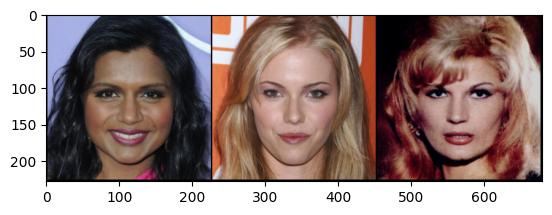

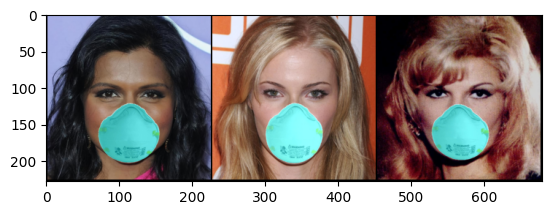

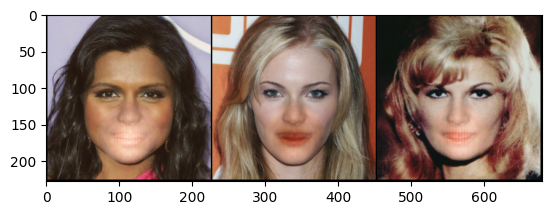

  8%|▊         | 30/363 [05:31<53:37,  9.66s/it]

In [ ]:
train2(True)